<a href="https://colab.research.google.com/github/Czedros/CSE352-Machine-Learning-Assignments/blob/main/CSE352MidtermMakeupAssignmentComplete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Introduction**

Name: [Enter Here]

I understand that my submission needs to be my own work: [Initials]

I understand that ChatGPT / Copilot / other AI tools are not allowed:  [Initials]

Total Points: **X**

Complete this notebook and submit it (save/print as pdf). Make sure all output is correct in the pdf before submitting (it sometimes gets cut off).

 The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## **Overview**

In this assignment, you will:
- Implement the rules and structure for Ultimate Tic-Tac-Toe
- Design a Monte Carlo Tree Search (MCTS) agent
- Improve your Monto Carlo Tree Search Agent
- Defeat a Cohort of Challengers with your agent.


---



#**Ultimate Tic-Tac-Toe**

Ultimate Tic-Tac-Toe is a strategic extension of the classic Tic-Tac-Toe game. Rather than a single 3×3 grid, Ultimate Tic-Tac-Toe consists of a 3×3 grid where each cell contains another 3×3 Tic-Tac-Toe board. This layered setup creates a more complex game structure requiring players to think multiple moves ahead.

The game was first popularized online in the early 2010s and is designed to emphasize positional play, long-term strategy, and adaptation to an evolving board state. Each player, X or O, takes turns placing their mark in a cell of one of the smaller boards. However, the twist lies in the move constraints: a player’s move determines which of the nine small boards their opponent must play in next. Specifically, if a player places their mark in cell (i, j) of a small board, their opponent must play in the (i, j) small board on their next turn.

The objective is to win the larger game by winning three small boards in a row—horizontally, vertically, or diagonally—similar to classic Tic-Tac-Toe. A small board is won when a player has three marks in a row within it. If a player is sent to a board that is already won or drawn, they may play in any open board of their choosing.

Ultimate Tic-Tac-Toe presents a more intricate challenge than its predecessor and is a rich environment for studying game trees, simulation-based planning, and reinforcement learning.

Additional Reading:

[Wikipedia page](https://en.wikipedia.org/wiki/Ultimate_tic-tac-toe).


[Quick Video Demonstration on how the Game works](https://www.youtube.com/shorts/_Na3a1ZrX7c) (Credit: VSauce)

[More In-Depth Guide](https://www.youtube.com/watch?v=37PC0bGMiTI) (Credit: MindYourDecisions - Presh Talwalkar)


---



#Visualizer Helper

There are 2 ways to go about creating a board for Ultimate Tic Tac Toe, a 9x9 grid or a 3x3 of 3x3 grids. These will result in different ways to visualize the board.


The following is a visuzlizing tool and 2 adapters that can be used depending on your implementation of the game.

#Implementation 1: 9x9 Boards

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def draw_ultimate_board(board, small_board_winners=None, last_move=None, highlight=None):
    """
    Visualizes a 9x9 Ultimate Tic-Tac-Toe board:
    - Grays out small boards that have been won
    - Draws a large X or O over won small boards
    - Highlights last move in bold
    - Red border for active small board
    """
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)

    # Draw grid
    for i in range(10):
        lw = 2 if i % 3 == 0 else 0.5
        ax.axhline(i, color='black', lw=lw, zorder=0)
        ax.axvline(i, color='black', lw=lw, zorder=0)

    # Draw faded backgrounds for won small boards
    if small_board_winners:
        for br in range(3):
            for bc in range(3):
                winner = small_board_winners[br][bc]
                if winner in [1, 2]:
                    rect = plt.Rectangle((bc*3, 6 - br*3), 3, 3, color='gray', alpha=0.6, zorder=1)
                    ax.add_patch(rect)
                    ax.text(bc*3 + 1.5, 7.5 - br*3, 'X' if winner == 1 else 'O',
                            fontsize=80, ha='center', va='center', color='black', alpha=1, zorder=2)

    # Draw pieces
    for row in range(9):
        for col in range(9):
            val = board[row, col]
            if val == 1:
                ax.text(col+0.5, 8.5 - row, 'X', ha='center', va='center', fontsize=16,
                        fontweight='bold' if (last_move == (row, col)) else 'normal', zorder=3)
            elif val == 2:
                ax.text(col+0.5, 8.5 - row, 'O', ha='center', va='center', fontsize=16,
                        fontweight='bold' if (last_move == (row, col)) else 'normal', zorder=3)

    # Highlight active small board
    if highlight:
        hrow, hcol = highlight
        x0 = hcol * 3
        y0 = 6 - hrow * 3
        ax.plot([x0, x0+3], [y0, y0], color='red', lw=4, zorder=4)
        ax.plot([x0, x0+3], [y0+3, y0+3], color='red', lw=4, zorder=4)
        ax.plot([x0, x0], [y0, y0+3], color='red', lw=4, zorder=4)
        ax.plot([x0+3, x0+3], [y0, y0+3], color='red', lw=4, zorder=4)

    plt.show()



##An example of the visualizer code and how its used

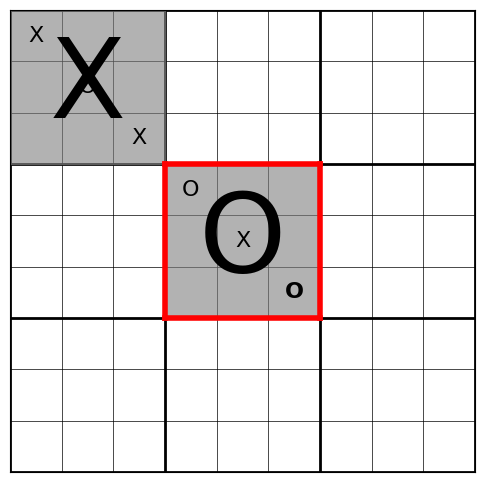

In [ ]:
test_board = np.zeros((9, 9), dtype=int)
test_board[0, 0] = 1
test_board[1, 1] = 1
test_board[2, 2] = 1
test_board[3, 3] = 2
test_board[4, 4] = 2
test_board[5, 5] = 2

small_board_winners = [
    [1, 0, 0],
    [0, 2, 0],
    [0, 0, 0]
]

last_move = (5, 5)
highlight = (1, 1)

draw_ultimate_board(test_board, small_board_winners, last_move, highlight)

#Adapter 1: Using 3x3 of 3x3 arrays

In [ ]:
def nested_list_to_board(nested_game, highlight=None, last_move=None, winners=None):
    board_array = np.zeros((9, 9), dtype=int)
    for br in range(3):
        for bc in range(3):
            sb = nested_game[br][bc]
            if isinstance(sb, np.ndarray):
                board_array[br*3:(br+1)*3, bc*3:(bc+1)*3] = sb
            else:
                board_array[br*3:(br+1)*3, bc*3:(bc+1)*3] = np.array(sb)

    draw_ultimate_board(board_array, small_board_winners=winners, last_move=last_move, highlight=highlight)

##Example Usage

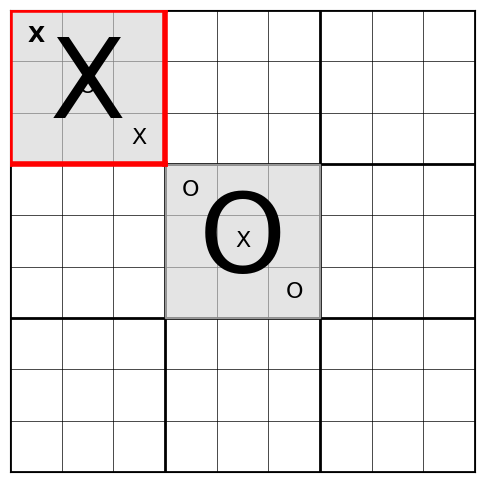

In [ ]:
nested_game = [
    [np.array([[1,0,0],[0,1,0],[0,0,1]]), np.zeros((3,3)), np.zeros((3,3))],
    [np.zeros((3,3)), np.array([[2,0,0],[0,2,0],[0,0,2]]), np.zeros((3,3))],
    [np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3))]
]

winners = [
    [1, 0, 0],
    [0, 2, 0],
    [0, 0, 0]
]

nested_list_to_board(nested_game, highlight=(0,0), last_move=(0,0), winners=winners)


#Part 1: Ultimate Tic-Tac-Toe [X Points]
In the first part, you will implement the mechanics of Ultimate Tic-Tac-Toe, defining how the game progresses and determining legal moves and win conditions.

There are an infinite number of ways to do this, and the guidelines will be pretty Lax

Here are two reccomended Methods and the Specifications

##Method 1: 3x3 Implementation

- Create a Small Board Class that contains a basic Tic-Tac-Toe Game
- Create a Big Board Class that contains a 3x3 grid of Small boards
- Implement logic for Tic tac toe..

##Method 2: Loose 9x9 Implementation
- Make a 9x9 grid
- Whenever a Move is made, Check for legality of the move and make it
- Check for wins via checking every 3x3 in code.

##Requirements

Regardless of the methods, several things are mandatory.

- get_legal_moves(self) : Gives a list of legal plays (This is important for the bots!)

- use big_r, big_c, small_r, small_c as the format of the moves (This is important for the bots!)


(Alternatively, give this to students as is, and have them complete just the bots,those are alot of work already, and this was pretty simple)

In [ ]:
import numpy as np
import random

class SmallBoard:
    def __init__(self):
        self.grid = np.zeros((3, 3), dtype=int)  # 0 = empty, 1 = X, 2 = O
        self.winner = 0
        self.active = True

    def play_move(self, row, col, player):
        if self.grid[row, col] != 0 or not self.active:
            return False
        self.grid[row, col] = player
        self.check_winner()
        return True

    def check_winner(self):
        for i in range(3):
            if np.all(self.grid[i, :] == self.grid[i, 0]) and self.grid[i, 0] != 0:
                self._declare_winner(self.grid[i, 0])
                return
            if np.all(self.grid[:, i] == self.grid[0, i]) and self.grid[0, i] != 0:
                self._declare_winner(self.grid[0, i])
                return
        if np.all(np.diag(self.grid) == self.grid[0, 0]) and self.grid[0, 0] != 0:
            self._declare_winner(self.grid[0, 0])
            return
        if np.all(np.diag(np.fliplr(self.grid)) == self.grid[0, 2]) and self.grid[0, 2] != 0:
            self._declare_winner(self.grid[0, 2])
            return
        if np.all(self.grid != 0):
            self._declare_winner(-1)

    def _declare_winner(self, winner):
        self.winner = winner
        self.active = False


In [ ]:
class UltimateBoard:
    def __init__(self):
        self.boards = [[SmallBoard() for _ in range(3)] for _ in range(3)]
        self.current_player = 1  # 1 = X, 2 = O
        self.next_board = None
        self.global_winner = 0
        self.last_move = None

    def play_move(self, big_r, big_c, small_r, small_c):
        board = self.boards[big_r][big_c]
        if self.next_board and (big_r, big_c) != self.next_board:
            print("You must play in board", self.next_board)
            return False
        if not board.play_move(small_r, small_c, self.current_player):
            print("Invalid move.")
            return False

        next_r, next_c = small_r, small_c
        if self.boards[next_r][next_c].active:
            self.next_board = (next_r, next_c)
        else:
            self.next_board = None

        self.check_global_winner()
        self.current_player = 3 - self.current_player
        self.last_move = (big_r, big_c, small_r, small_c)
        return True

    def check_global_winner(self):
        grid = np.array([[b.winner if b.winner > 0 else 0 for b in row] for row in self.boards])
        for i in range(3):
            if np.all(grid[i, :] == grid[i, 0]) and grid[i, 0] != 0:
                self.global_winner = grid[i, 0]
                return
            if np.all(grid[:, i] == grid[0, i]) and grid[0, i] != 0:
                self.global_winner = grid[0, i]
                return
        if np.all(np.diag(grid) == grid[0, 0]) and grid[0, 0] != 0:
            self.global_winner = grid[0, 0]
            return
        if np.all(np.diag(np.fliplr(grid)) == grid[0, 2]) and grid[0, 2] != 0:
            self.global_winner = grid[0, 2]
            return

    def get_legal_moves(self):
        moves = []
        for big_r in range(3):
            for big_c in range(3):
                board = self.boards[big_r][big_c]
                if self.next_board and (big_r, big_c) != self.next_board:
                    continue
                if board.active:
                    for i in range(3):
                        for j in range(3):
                            if board.grid[i, j] == 0:
                                moves.append((big_r, big_c, i, j))
        return moves

    def display(self):
        def cell_symbol(val):
            return '.' if val == 0 else ('X' if val == 1 else 'O')
        for big_r in range(3):
            for r in range(3):
                line = ''
                for big_c in range(3):
                    board = self.boards[big_r][big_c]
                    line += ' '.join(cell_symbol(board.grid[r, c]) for c in range(3)) + ' | '
                print(line)
            print('-' * 20)


In [ ]:
def ultimate_board_to_board(game, highlight=None):
    board_array = np.zeros((9, 9), dtype=int)
    small_board_winners = [[game.boards[r][c].winner for c in range(3)] for r in range(3)]
    last_move = None
    if hasattr(game, 'last_move') and game.last_move:
        br, bc, sr, sc = game.last_move
        last_move = (br*3 + sr, bc*3 + sc)

    for br in range(3):
        for bc in range(3):
            sb = game.boards[br][bc].grid
            board_array[br*3:(br+1)*3, bc*3:(bc+1)*3] = sb

    if highlight is None and hasattr(game, 'next_board') and not game.global_winner:
        highlight = game.next_board

    draw_ultimate_board(board_array, small_board_winners=small_board_winners,
                        last_move=last_move, highlight=highlight)


In [ ]:
def play_game(agent_X=None, agent_O=None):
    game = UltimateBoard()

    while not game.global_winner and game.get_legal_moves():
        print("\nCurrent Turn: Player {}".format("X" if game.current_player == 1 else "O"))
        ultimate_board_to_board(game)

        if game.next_board:
            print("You must play in small board:", game.next_board)
        else:
            print("You may play in any board.")

        # Determine agent for this turn
        agent = agent_X if game.current_player == 1 else agent_O

        if agent is None:
            # Human move
            move = input("Enter your move (big_r big_c small_r small_c): ").split()
            try:
                move = tuple(map(int, move))
                if len(move) != 4 or not game.play_move(*move):
                    print("Try again.")
            except:
                print("Invalid input.")
        else:
            # Bot move
            move = agent(game)
            print(f"Bot plays: {move}")
            game.play_move(*move)

    ultimate_board_to_board(game)
    if game.global_winner:
        print("Winner: Player", "X" if game.global_winner == 1 else "O")
    else:
        print("Game ended in a draw.")

#Test 1: Random Bot

Implement a bot that makes Random Moves, and have it play against itself! Use this to test out whether your game is working correctly, and see how the game plays.


In [ ]:
def random_bot(board: UltimateBoard):
    return random.choice(board.get_legal_moves())

def play_botvbot_game(agent_X=None, agent_O=None):
    game = UltimateBoard()

    while not game.global_winner and game.get_legal_moves():
        agent = agent_X if game.current_player == 1 else agent_O

        if agent is None:
            move = input("Enter your move (big_r big_c small_r small_c): ").split()
            try:
                move = tuple(map(int, move))
                if len(move) != 4 or not game.play_move(*move):
                    print("Try again.")
            except:
                print("Invalid input.")
        else:
            move = agent(game)
            game.play_move(*move)

    print("\nFinal Result:")
    ultimate_board_to_board(game)
    if game.global_winner:
        print("Winner: Player", "X" if game.global_winner == 1 else "O")
    else:
        print("Game ended in a draw.")

    return game.global_winner

play_botvbot_game(agent_X=random_bot, agent_O=random_bot)

#**Part 2: Monte Carlo Tree Search [X Points]**

The second part of this assignment is creating an agent that uses Monte-Carlo Tree Search (MCTS) that can take a game to play it.

##**A Quick Introduction to MCTS**
Monte Carlo Tree Search (MCTS) is a popular algorithm for making decisions in large, complex environments, especially games like Go, Chess, and Ultimate Tic-Tac-Toe.

At its core, MCTS builds a search tree dynamically by simulating many possible future plays of the game. Instead of analyzing all moves exhaustively (which would be impossible in very large games), it randomly explores promising options and gradually focuses on the best strategies.

**MCTS operates through four key phases:**

- **Selection**
  - Starting at the root, recursively select child nodes that appear most promising, balancing exploration (trying new moves) and exploitation (choosing moves known to be good).
- **Expansion**
  - When reaching a node with unexplored moves, add one or more child nodes representing these new possibilities.
- **Simulation (Rollout)**
  - From the newly expanded node, simulate a random (or semi-random) playout to the end of the game to estimate how good that move might be.
- **Backpropagation**
  - Propagate the result of the simulation back up the tree, updating statistics (like win counts) for all nodes visited during selection.

By repeating these four phases a number of times, MCTS gradually builds a "map" of the most promising moves without ever having to fully solve the game.

##Additional Resources
- [Wikipedia](https://en.wikipedia.org/wiki/Monte_Carlo_tree_search)
- [Builtin](https://builtin.com/machine-learning/monte-carlo-tree-search)
- [Video](https://www.youtube.com/watch?v=UXW2yZndl7U) by John Levine


---



#**Part 2: Implementation**

For this, we will be splitting it into 4 small componnets:

- Component 1: MCTS Nodes

- Component 2: State Copy Function

- Component 3: MCTS Main Loop


---



## **Component 1: MCTS Nodes**

The first of these components is the Node itself.

Each node should:

- Store the state of the game at that point.

- Keep track of which move led to that node from its parent.

- Record statistics like how many times it has been visited, and what the total reward is.

- Track which moves are still untried from that position.

The node should allow you to:

- Check if it’s fully expanded (i.e., all moves have been tried).

- Select one of its children to continue searching, balancing exploitation (good moves) and exploration (trying unknown moves).

You are encouraged to use a well-known formula like UCB1 for this purpose.

In [ ]:
import random
import math

class MCTSNode:
    def __init__(self, game_state, parent=None, move=None):
        self.game_state = game_state
        self.parent = parent
        self.move = move
        self.children = []
        self.visits = 0
        self.total_reward = 0.0
        self.untried_moves = game_state.get_legal_moves() if game_state.global_winner == 0 else []

    def is_fully_expanded(self):
        return len(self.untried_moves) == 0

    def select_child(self, exploration_weight=1.414):
        best_score = -float('inf')
        best_children = []

        for child in self.children:
            if child.visits == 0:
                score = float('inf')
            else:
                # UCB1 formula
                exploitation = child.total_reward / child.visits
                exploration = exploration_weight * math.sqrt(math.log(self.visits) / child.visits)
                score = exploitation + exploration
            if score > best_score:
                best_score = score
                best_children = [child]
            elif score == best_score:
                best_children.append(child)
        return random.choice(best_children)

    def __repr__(self):
        return f"Node(move={self.move}, visits={self.visits}, reward={self.total_reward})"


## **Component 2: State Copying**

Since MCTS simulates future moves many times, it’s important that changing the board in one simulation does not affect the real game.

The second important component here is a function that makes copyies of the Ultimate-Tic-Tac-Toe Board

Think about how to create an independent copy of:

- The board's current layout,

- Which player’s turn it is,

- Any extra game metadata (e.g., where the next move must be played).

In [ ]:
def copy_ultimate_board(original):
    new_board = UltimateBoard()
    new_board.current_player = original.current_player
    new_board.next_board = original.next_board
    new_board.global_winner = original.global_winner

    for i in range(3):
        for j in range(3):
            orig_sb = original.boards[i][j]
            new_sb = SmallBoard()
            new_sb.grid = orig_sb.grid.copy()
            new_sb.winner = orig_sb.winner
            new_sb.active = orig_sb.active
            new_board.boards[i][j] = new_sb
    return new_board


## **Component 3: MCTS Main Loop**

The Final component is the Main Loop/function itself. This is where we tie together all the components and complete the expansion and selection side of things.

##This includes:

Expanding New Moves
- When reaching a node where there are still moves that haven't been tried:
  - Pick one of the untried moves,
  - Create a new node representing the resulting game state after playing that move,
  - Add it to the tree.


Simulating a Random Game (Rollout)
- From the newly created node:
  - Play random moves until the game ends (win, lose, or draw).
  - This simulation does not have to be smart — just choose valid random moves at each step.

Backpropagating Results
- After the simulation finishes:
  - Update statistics for all nodes along the path you traversed (from root to leaf).
  - Each node should record:
    - One more visit
    - An updated total reward depending on the result.

- When updating rewards:
  - Reward should be viewed from the perspective of the root player,  not from the perspective of the node’s current player.

Choosing the Final Move
- After running many simulations:
  - Look at all the children of the root node,
  - Choose the child that was visited the most during search,
  - Return the move that led to that child.


In [ ]:
def mcts(ultimate_board, iterations=500):
    root = MCTSNode(copy_ultimate_board(ultimate_board))

    for _ in range(iterations):
        node = root
        path = [node]

        # Selection
        while not node.game_state.global_winner and node.is_fully_expanded() and node.children:
          node = node.select_child()
          path.append(node)

        # If game ended in this node, results
        if node.game_state.global_winner != 0:
            reward = 0.0
            if node.game_state.global_winner == root.game_state.current_player:
                reward = 1.0
            elif node.game_state.global_winner == -1:
                reward = 0.5
        else:
            # Expansion
            if node.untried_moves:
                move = node.untried_moves.pop()
                new_game = copy_ultimate_board(node.game_state)
                new_game.play_move(*move)
                child = MCTSNode(new_game, parent=node, move=move)
                node.children.append(child)
                path.append(child)
                node = child

            # Simulation
            sim_game = copy_ultimate_board(node.game_state)
            while sim_game.global_winner == 0 and sim_game.get_legal_moves():
                move = random.choice(sim_game.get_legal_moves())
                sim_game.play_move(*move)

            # Determine reward from root player's perspective
            if sim_game.global_winner == root.game_state.current_player:
                reward = 1.0
            elif sim_game.global_winner == -1:
                reward = 0.5
            else:
                reward = 0.0

        # Backpropagation
        for n in path:
            n.visits += 1
            n.total_reward += reward

    if not root.children:
        return random.choice(ultimate_board.get_legal_moves())

    best_move = max(root.children, key=lambda c: c.visits).move
    return best_move

##**Testing Your MCTS Bot** (X Points)

Have your MCTS Bot play against both the random agent for 5 games, and have it play against itself for 5 games.

Modify its iteration count for each of the games, and then do the following for each game:

- Print out a table containing the Iteration count and its corresponding winrate

- Perform small write up on the results, and if they matched your predictions


In [ ]:
import numpy as np
import random

iteration_counts = [50,100,200,400,800]

results_vs_random = []
results_vs_self = []

def mcts_agent_factory(iterations):
    def agent(game):
        return mcts(game, iterations=iterations)
    return agent

print("Testing MCTS vs Random Agent...\n")
for iters in iteration_counts:
    wins = 0
    for _ in range(5):
        mcts_agent = mcts_agent_factory(iters)
        winner = play_botvbot_game(mcts_agent, random_bot)
        if winner == 1:
            wins += 1
    winrate = wins / 5
    results_vs_random.append((iters, winrate))
    print(f"Iterations: {iters} | Winrate vs Random: {winrate:.2f}")

print("\nTesting MCTS vs MCTS...\n")
for iters in iteration_counts:
    wins = 0
    for _ in range(5):
        mcts_agent = mcts_agent_factory(iters)
        winner = play_botvbot_game(mcts_agent, mcts_agent_factory(iters))
        if winner == 1:
            wins += 1
    winrate = wins / 5
    results_vs_self.append((iters, winrate))
    print(f"Iterations: {iters} | Winrate vs Self (X winrate): {winrate:.2f}")

import pandas as pd

df_random = pd.DataFrame(results_vs_random, columns=["Iterations", "Winrate_vs_Random"])
df_self = pd.DataFrame(results_vs_self, columns=["Iterations", "Winrate_vs_SelfPlay"])

print("\nSummary Table: MCTS vs Random")
print(df_random)

print("\nSummary Table: MCTS vs MCTS")
print(df_self)

# **Part 3: Improving the Bot** (X Points)

Now that we have a basic implementation of MCTS, Lets improve it.

Lets look at Improving the rollout/simulation function and the Reward System for our bot.

Write an Enhanced Version of your MCTS Bot that implements the following to your Rollout Function and Reward System.

- A Smarter Rollout/Simulation Function (Non-random simulation heuristics)

- Develop better rewards:

- Improving the Node Selection Formula:

If you would like some help or additional reading to understand this better:

- [Reading 1 (Reccomended)](https://www.uttt.ai/blog)
- [Reading 2 (Complicated)](https://suragnair.github.io/posts/alphazero.html)
- [Reading 3 (LONG)](https://philhchen.github.io/files/tictactoe-paper.pdf)


---



## **Improvement 1: Nodes!**

The first of these Improvements is to the MCTS Node.

In the basic MCTS version, all legal moves were treated equally during expansion and selection. But not all moves are equal.

Some positions (like the center of a board) are much stronger than others — and experienced players (and bots!) often prioritize these.

You should modify how your nodes prioritize which moves to try. Specifically:

- Assign a “prior score” or weight to each move, based on how good it seems before simulating it.

- Use this prior to bias the move selection during tree search.

Here are some simple heuristics you can use to score moves:

- Moves to the center of a small board are better.

- Corner positions are better than sides.

- If a move wins a small board, it's much better.

- Moves that send the opponent to a finished board (giving you more freedom) are better.

Another Improvement is the formula used!

- If you used UCB1, you should improve the formula to the PUCT

(Read [this](https://towardsdatascience.com/playing-chess-with-a-generalized-ai-b83d64ac71fe/) to get some insight)

In [ ]:
import math
import random
import numpy as np

class EnhancedMCTSNode:
    def __init__(self, game_state, parent=None, move=None):
        self.game_state = game_state
        self.parent = parent
        self.move = move
        self.children = []
        self.visits = 0
        self.total_reward = 0.0
        self.prior = 1.0  # Prior probability for PUCT
        self.untried_moves = self._prioritized_moves(game_state.get_legal_moves())

    def _prioritized_moves(self, moves):
        prioritized = []
        for move in moves:
            small_r, small_c = move[2], move[3]
            priority = 1.0
            if (small_r, small_c) in [(1,1)]:  # Center
                priority = 1.5
            elif (small_r%2 == 0) and (small_c%2 == 0):  # Corners
                priority = 1.2
            prioritized.append((move, priority))
        return prioritized

    def is_fully_expanded(self):
        return len(self.untried_moves) == 0

    def select_child(self, c_puct=1.5):
        # PUCT formula: argmax(Q(s,a) + c_puct * P(s,a) * sqrt(N(s)) / (1 + N(s,a)))
        total_n = math.sqrt(self.visits)
        best_score = -float('inf')
        best_child = None

        for child in self.children:
            if child.visits == 0:
                q_value = 0
            else:
                q_value = child.total_reward / child.visits

            puct_value = c_puct * child.prior * total_n / (1 + child.visits)
            score = q_value + puct_value

            if score > best_score:
                best_score = score
                best_child = child
        return best_child

    def __repr__(self):
        return f"Node(move={self.move}, visits={self.visits}, reward={self.total_reward})"


## **Improvement 2: Reward Systems!**

Your basic agent treated outcomes as either a win (1), tie (0.5), or loss (0).
This is very coarse and only tells the agent if it won at the end — it doesn’t help during the rest of the game.

Instead, you should define a reward function that can give credit for partial progress — even if the game hasn’t ended yet.

Improve/Create the system so that it rewards:

- Rewards winning a small board (e.g., +0.1),

- Penalizes losing a small board (e.g., -0.1),

- Gives extra reward for controlling multiple boards in a row, or the center board,

- Still gives a larger reward for winning the full game (e.g., +1.0), and a smaller reward for drawing (e.g., 0.4),

- Optionally uses a squashing function (like tanh) to keep values in a reasonable range.

This lets your MCTS agent backpropagate better signals — not just "Did I win?" but rather "How good is this board overall?"

In [ ]:
def calculate_reward(final_state, root_player):
    if final_state.global_winner == root_player:
        return 1.0
    if final_state.global_winner == -1:
        return 0.4
    if final_state.global_winner == 3 - root_player:
        return -1.0

    score = 0
    small_board_counts = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            if final_state.boards[i][j].winner == root_player:
                score += 0.1
                small_board_counts[i,j] = 1
            elif final_state.boards[i][j].winner == 3 - root_player:
                score -= 0.1
                small_board_counts[i,j] = -1

    for i in range(3):
        row_sum = np.sum(small_board_counts[i,:])
        col_sum = np.sum(small_board_counts[:,i])
        if abs(row_sum) == 3 or abs(col_sum) == 3:
            score += 0.3 * np.sign(row_sum if abs(row_sum)==3 else col_sum)

    return np.tanh(score)

## **Improvement 3: Main Loop (Propogation/Simulation)**

In your original MCTS agent, simulations were completely random.
This works okay for simple games, but in Ultimate Tic-Tac-Toe, random play often leads to noisy, misleading results.

Your goal is to make the simulation (or "rollout") smarter, so it gives better estimates of move quality.

Try to update your simulation logic so that it uses a heuristic.

Ex.
 - Prefer moves that complete small boards.
 - Prioritize moves that block the opponent from winning small boards.
 - Avoid bad or useless moves (e.g., playing moves that results in letting the opponent play in any board).

You don’t need to build a full search or evaluation algorithm inside the simulation. But even a few simple heuristics can make the playouts way more realistic.

In [ ]:
def enhanced_simulation(game_state):
    sim_game = copy_ultimate_board(game_state)

    while sim_game.global_winner == 0 and sim_game.get_legal_moves():
        moves = sim_game.get_legal_moves()
        best_moves = []

        for move in moves:
            temp_game = copy_ultimate_board(sim_game)
            temp_game.play_move(*move)

            big_r, big_c = move[0], move[1]
            if temp_game.boards[big_r][big_c].winner == sim_game.current_player:
                best_moves.append(move)

        if best_moves:
            move = random.choice(best_moves)
        else:
            # Positional fallback: center > corner > edge
            scored = []
            for move in moves:
                sr, sc = move[2], move[3]
                if (sr, sc) == (1, 1):
                    score = 3
                elif sr % 2 == 0 and sc % 2 == 0:
                    score = 2
                else:
                    score = 1
                scored.append((move, score))

            max_score = max(score for _, score in scored)
            fallback = [m for m, s in scored if s == max_score]
            move = random.choice(fallback)

        sim_game.play_move(*move)

    return sim_game


def enhanced_mcts(ultimate_board, iterations=800):
    root = EnhancedMCTSNode(copy_ultimate_board(ultimate_board))

    for _ in range(iterations):
        node = root
        path = [node]

        # Selection
        while not node.game_state.global_winner and node.is_fully_expanded() and node.children:
            node = node.select_child()
            path.append(node)

        # Expansion
        if node.untried_moves and not node.game_state.global_winner:
            move, prior = node.untried_moves.pop()
            new_game = copy_ultimate_board(node.game_state)
            new_game.play_move(*move)
            child = EnhancedMCTSNode(new_game, parent=node, move=move)
            child.prior = prior
            node.children.append(child)
            path.append(child)
            node = child

        # Simulation
        final_state = enhanced_simulation(node.game_state)

        # Reward calculation
        reward = calculate_reward(final_state, root.game_state.current_player)

        # Backpropagation
        for n in path:
            n.visits += 1
            n.total_reward += reward

    if not root.children:
        return random.choice(ultimate_board.get_legal_moves())

    best_child = max(root.children, key=lambda c: c.visits)
    return best_child.move


#**Part 4: The Gauntlet** (X Points)

Lets do a set of 1v1 tests between your MCTS Agent and the less than perfect ones below.

The following are 3 additional Agents, each with a special quirk.

###For each agent:
- Complete the Predictions

- Have your Monte-Carlos Agent Play against the challenge Agent, at 4 different iteration counts. (5 game for each is good enough)

- Print out a table containing the Iteration count and its corresponding winrate

- Use the Visualizer to create a final board summary.

- Perform small write up on the results, and if they matched your predictions

Hint: You may be able to reuse your previous test code for Part 2's Testing here!

##Round 1: Improved vs Sir Abserd

Sir Abserd is as random as random comes, and makes moves with no rhyme or reason.

Abserd:
 - Makes Random Moves

In [ ]:
def agent_ser_abserd(board):
    return random.choice(board.get_legal_moves())

##Prediction:
- Give a Range, how many moves do you think it'll take to win?
- At what Iteration Count do you think it'll take your bot to reach above 50% win rate.

In [ ]:
import numpy as np
import random

iteration_counts = [50,100,200,400,800]

results = []

def mcts_agent_factory(iterations):
    def agent(game):
        return enhanced_mcts(game, iterations=iterations)
    return agent

print("Testing MCTS vs Abserd\n")
for iters in iteration_counts:
    wins = 0
    for _ in range(5):
        mcts_agent = mcts_agent_factory(iters)
        winner = play_botvbot_game(mcts_agent, agent_ser_abserd)
        if winner == 1:
            wins += 1
    winrate = wins / 5
    results.append((iters, winrate))
    print(f"Iterations: {iters} | Winrate vs Abserd: {winrate:.2f}")


import pandas as pd

df_random = pd.DataFrame(results, columns=["Iterations", "Winrate_vs_Abserd"])

print("\nSummary Table: MCTS vs Abserd")
print(df_random)

##**Round 2: Monte-Carlo vs Near Seer**
Near Seer can see the future, so long as it's within a 3x3 block.

Near Seer:
  - Tries to make a win on a small board if it sees one

In [ ]:
def agent_near_seer(board):
    moves = board.get_legal_moves()
    for move in moves:
        big_r, big_c, small_r, small_c = move
        small_board = board.boards[big_r][big_c]
        temp_grid = small_board.grid.copy()
        temp_grid[small_r, small_c] = board.current_player

        # Check for immediate win in small board
        for i in range(3):
            if all(temp_grid[i, :] == board.current_player) or all(temp_grid[:, i] == board.current_player):
                return move
        if all(np.diag(temp_grid) == board.current_player) or all(np.diag(np.fliplr(temp_grid)) == board.current_player):
            return move
    return random.choice(moves)

##Prediction:
- Give a Range, how many moves do you think it'll take to win?
- At what Iteration Count do you think it'll take your bot to reach above 50% win rate.

In [ ]:
import numpy as np
import random

iteration_counts = [50,100,200,400,800]

results = []

def mcts_agent_factory(iterations):
    def agent(game):
        return enhanced_mcts(game, iterations=iterations)
    return agent

print("Testing MCTS vs Seer\n")
for iters in iteration_counts:
    wins = 0
    for _ in range(5):
        mcts_agent = mcts_agent_factory(iters)
        winner = play_botvbot_game(mcts_agent, agent_near_seer)
        if winner == 1:
            wins += 1
    winrate = wins / 5
    results.append((iters, winrate))
    print(f"Iterations: {iters} | Winrate vs Seer: {winrate:.2f}")


import pandas as pd

df_random = pd.DataFrame(results, columns=["Iterations", "Winrate_vs_Seer"])

print("\nSummary Table: MCTS vs Seer")
print(df_random)

##**Round 3: Monte-Carlo vs Count Erfit**

Count Erfit tries to mirror his last move, and if he can't, he'll mirror your last move.

Count Erfit:
  - First, tries to play same (small_r, small_c) as last own move
  - If not available, tries to play the exact opponent last move
  - If not, plays random


In [ ]:
def count_erfit(board, last_self_move, last_opponent_move):
    moves = board.get_legal_moves()

    if last_self_move:
        _, _, last_small_r, last_small_c = last_self_move
        for move in moves:
            if move[2] == last_small_r and move[3] == last_small_c:
                return move

    if last_opponent_move:
        target_move = last_opponent_move
        if target_move in moves:
            return target_move

    # Otherwise random
    return random.choice(moves)
#Wrapper
def agent_count_erfit():
    last_self_move = [None]
    last_opponent_move = [None]

    def agent(game):
        move = count_erfit(game, last_self_move[0], last_opponent_move[0])
        last_opponent_move[0] = move
        last_self_move[0] = move
        return move

    return agent

##Prediction:
- Give a Range, how many moves do you think it'll take to win?
- At what Iteration Count do you think it'll take your bot to reach above 50% win rate.

In [ ]:
import numpy as np
import random

iteration_counts = [50,100,200,400,800]

results = []

def mcts_agent_factory(iterations):
    def agent(game):
        return enhanced_mcts(game, iterations=iterations)
    return agent

print("Testing MCTS vs Count\n")
for iters in iteration_counts:
    wins = 0
    for _ in range(5):
        mcts_agent = mcts_agent_factory(iters)
        winner = play_botvbot_game(mcts_agent, agent_count_erfit())
        if winner == 1:
            wins += 1
    winrate = wins / 5
    results.append((iters, winrate))
    print(f"Iterations: {iters} | Winrate vs Count: {winrate:.2f}")


import pandas as pd

df_random = pd.DataFrame(results, columns=["Iterations", "Winrate_vs_Count"])

print("\nSummary Table: MCTS vs Count")
print(df_random)

#**Final Test: Improved Monte-Carlo Vs Unimproved Monte-Carlo**

At the end of the Gaunlet, the greatest battle is against one-self.

For this test, have the your Improved Monte Carlo Implementation compete vs the basic version from Part 2.

This agent should match the improved version's Iteration Count


##Prediction:
- Give a Range, how many moves do you think it'll take to win?
- At what Iteration Count do you think it'll take your bot to reach above 50% win rate.

In [ ]:
import numpy as np
import random

iteration_counts = [50,100,200,400,800]

results = []

def mcts_agent_factory(iterations):
    def agent(game):
        return enhanced_mcts(game, iterations=iterations)
    return agent

def simple_agent_factory(iterations):
    def agent(game):
        return mcts(game, iterations=iterations)
    return agent

print("Testing MCTS vs Basic\n")
for iters in iteration_counts:
    wins = 0
    for _ in range(5):
        mcts_agent = mcts_agent_factory(iters)
        simple_agent = simple_agent_factory(iters)
        winner = play_botvbot_game(mcts_agent, simple_agent)
        if winner == 1:
            wins += 1
    winrate = wins / 5
    results.append((iters, winrate))
    print(f"Iterations: {iters} | Winrate vs Baic: {winrate:.2f}")


import pandas as pd

df_random = pd.DataFrame(results, columns=["Iterations", "Winrate_vs_Basic"])

print("\nSummary Table: Enhanced vs Basic")
print(df_random)

#Final Discussion!

Think about the 4 tests we have done with the Improved Monte-Carlo Implementation.

Can the Monte-Carlo bot be improved any further? If so, how? If not, why not?